# Imports

In [1]:
!pip install -q tfds-nightly tensorflow-datasets tensorflow matplotlib

     |████████████████████████████████| 4.1 MB 13.4 MB/s 


In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load dataset

Import dataset

In [3]:
ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling deep_weeds-train.tfrecord...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


In [4]:
images, labels = ds['train']

# Preprocessing

In [5]:
print(images.shape)
print(images.dtype)

(17509, 256, 256, 3)
<dtype: 'uint8'>


In [6]:
resized_images = tf.image.resize(images, [64,64])
resized_images_32 = tf.image.resize(images, [32,32])
image_vectors = tf.reshape(resized_images_32, [-1,3072])

In [7]:
print(resized_images.shape)

(17509, 64, 64, 3)


In [8]:
print(image_vectors.shape)

(17509, 3072)


Edge detection

In [9]:
edges = tf.image.sobel_edges(tf.cast(tf.image.rgb_to_grayscale(resized_images), tf.float32))

In [10]:
edges_combined = tf.sqrt(tf.math.reduce_sum(edges**2, axis=-1))

In [11]:
edges_combined_scaled = tf.divide(tf.subtract(edges_combined, tf.reduce_min(edges_combined)), tf.subtract(tf.reduce_max(edges_combined), tf.reduce_min(edges_combined)))*255

In [50]:
edges_vectors = tf.reshape(edges_combined_scaled, [-1,4096])

In [12]:
print(tf.math.reduce_max(edges_combined_scaled))

tf.Tensor(255.0, shape=(), dtype=float32)


Here's a sample of an image after downres

Text(0.5, 1.0, 'After')

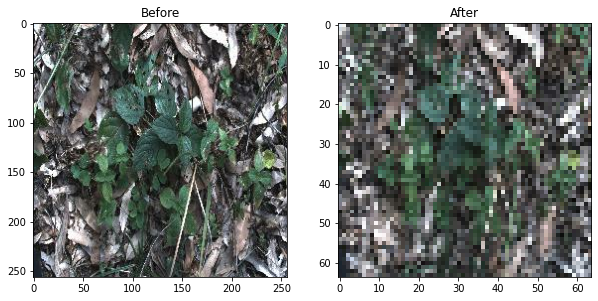

In [13]:
before = images[0]
after = tf.cast(resized_images[0], tf.uint8)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,2,1)
plt.imshow(before)
ax.set_title("Before")

ax = fig.add_subplot(1,2,2)
plt.imshow(after)
ax.set_title("After")

sample of image after edge detection

Text(0.5, 1.0, 'AfterC')

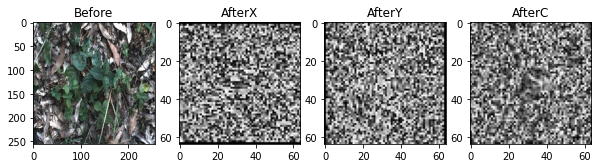

In [14]:
before = images[0]
after = tf.cast(edges[0], tf.uint8)
afterc = tf.cast(edges_combined[0], tf.uint8)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,4,1)
plt.imshow(before)
ax.set_title("Before")

ax = fig.add_subplot(1,4,2)
plt.imshow(after[:,:,0,0], cmap='gray', vmin=0, vmax=255)
ax.set_title("AfterX")

ax = fig.add_subplot(1,4,3)
plt.imshow(after[:,:,0,1], cmap='gray', vmin=0, vmax=255)
ax.set_title("AfterY")

ax = fig.add_subplot(1,4,4)
plt.imshow(afterc[:,:,0], cmap='gray', vmin=0, vmax=255)
ax.set_title("AfterC")

#Validation function

In [40]:
def validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, param_dict):
  X_tval, X_val, y_tval, y_val = train_test_split(X_train, y_train, test_size=0.2)
  score_array = []
  for n in list(param_dict.values())[0]:
    im_pipeline.set_params(**{list(param_dict.keys())[0]:n})
    im_pipeline.fit(X_tval, y_tval)
    y_val_pred = im_pipeline.predict(X_val)
    score_array.append(f1_score(y_val, y_val_pred, average='micro'))
  return score_array

#KNN on 32\*32\*3 pixels with LDA with V and undersampling

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_vectors.numpy(), labels.numpy(), test_size=0.2)

In [74]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import f1_score

In [75]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
im_pipeline = make_pipeline(undersampler, lda, knn)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'kneighborsclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


Text(0, 0.5, 'mean test scores')

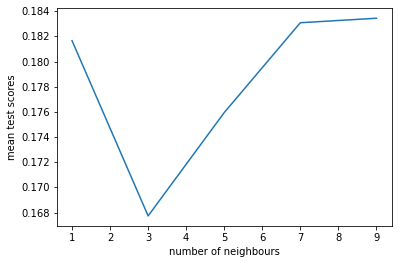

In [76]:
param_name = 'kneighborsclassifier__n_neighbors'
param_values = [x for x in range(1, 10) if x%2 != 0]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

Actual Model:

In [169]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [170]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [171]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, metric='euclidean')
knn_model = knn.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_knn = knn.predict(X_test_LDA)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.07      0.13      0.09       208
           1       0.04      0.07      0.05       207
           2       0.07      0.14      0.10       206
           3       0.10      0.16      0.13       213
           4       0.07      0.12      0.09       213
           5       0.05      0.08      0.06       193
           6       0.07      0.18      0.10       211
           7       0.07      0.11      0.08       204
           8       0.58      0.13      0.21      1847

    accuracy                           0.13      3502
   macro avg       0.12      0.13      0.10      3502
weighted avg       0.34      0.13      0.15      3502



Text(0.5, 33.0, 'Predicted')

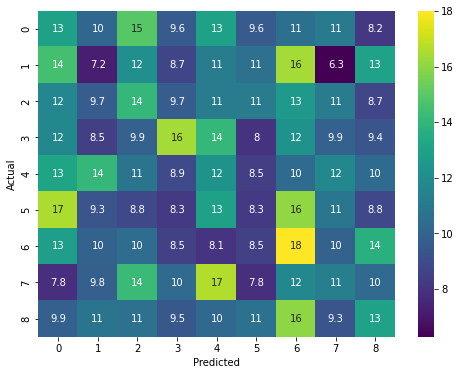

In [172]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#KNN on engineered features with LDA with V and undersampling

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(edges_vectors.numpy(), labels.numpy(), test_size=0.2)

In [82]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import f1_score

In [83]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
im_pipeline = make_pipeline(undersampler, lda, knn)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'kneighborsclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


Text(0, 0.5, 'mean test scores')

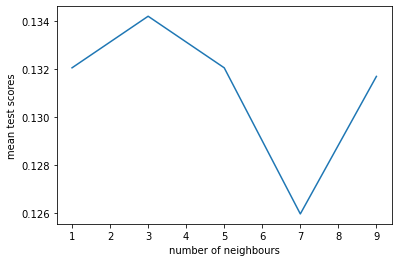

In [84]:
param_name = 'kneighborsclassifier__n_neighbors'
param_values = [x for x in range(1, 10) if x%2 != 0]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

Actual Model:

In [165]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [166]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [167]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 3, metric='euclidean')
knn_model = knn.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_knn = knn.predict(X_test_LDA)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.06      0.11      0.08       208
           1       0.07      0.14      0.09       207
           2       0.07      0.16      0.10       206
           3       0.09      0.16      0.12       213
           4       0.08      0.14      0.10       213
           5       0.07      0.11      0.08       193
           6       0.07      0.16      0.10       211
           7       0.07      0.12      0.09       204
           8       0.57      0.13      0.21      1847

    accuracy                           0.13      3502
   macro avg       0.13      0.13      0.11      3502
weighted avg       0.34      0.13      0.15      3502



Text(0.5, 33.0, 'Predicted')

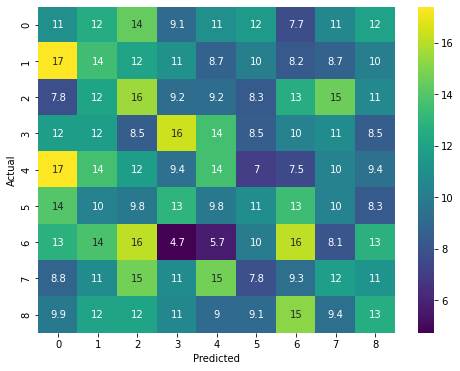

In [168]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#SVM on pixels with LDA with V and undersampling

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_vectors.numpy(), labels.numpy(), test_size=0.2)

In [90]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score

In [91]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
svmclf = svm.SVC(kernel='rbf')
im_pipeline = make_pipeline(undersampler, lda, svmclf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'svc', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


Text(0, 0.5, 'mean test scores')

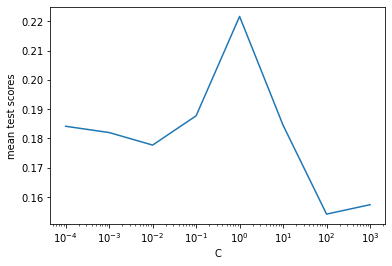

In [92]:
param_name = 'svc__C'
param_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [161]:
from sklearn import svm
from sklearn.metrics import classification_report

In [162]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [163]:
svmclf = svm.SVC(kernel='rbf', C=1)
svm_model = svmclf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_svm = svmclf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.08      0.25      0.12       208
           1       0.06      0.11      0.07       207
           2       0.07      0.15      0.10       206
           3       0.08      0.11      0.09       213
           4       0.08      0.14      0.10       213
           5       0.05      0.07      0.05       193
           6       0.07      0.15      0.10       211
           7       0.07      0.09      0.08       204
           8       0.57      0.11      0.19      1847

    accuracy                           0.12      3502
   macro avg       0.12      0.13      0.10      3502
weighted avg       0.33      0.12      0.14      3502



Text(0.5, 33.0, 'Predicted')

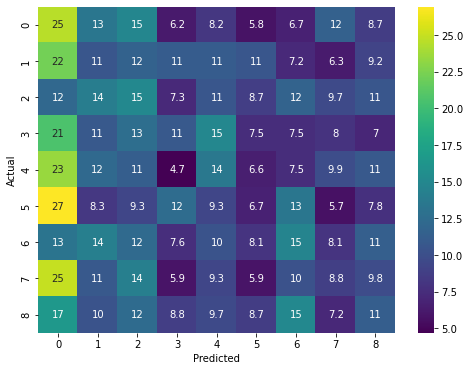

In [164]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#SVM on engineered features with LDA with V and undersampling

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(edges_vectors.numpy(), labels.numpy(), test_size=0.2)

In [98]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score

In [99]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
svmclf = svm.SVC(kernel='rbf')
im_pipeline = make_pipeline(undersampler, lda, svmclf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'svc', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


Text(0, 0.5, 'mean test scores')

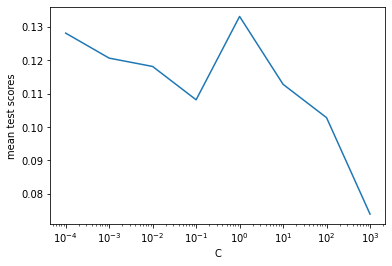

In [100]:
param_name = 'svc__C'
param_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [157]:
from sklearn import svm
from sklearn.metrics import classification_report

In [158]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [159]:
svmclf = svm.SVC(kernel='rbf', C=1)
svm_model = svmclf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_svm = svmclf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.06      0.12      0.08       208
           1       0.06      0.10      0.07       207
           2       0.06      0.15      0.08       206
           3       0.07      0.11      0.09       213
           4       0.06      0.10      0.07       213
           5       0.06      0.09      0.07       193
           6       0.07      0.19      0.10       211
           7       0.07      0.08      0.07       204
           8       0.62      0.12      0.20      1847

    accuracy                           0.12      3502
   macro avg       0.12      0.12      0.09      3502
weighted avg       0.35      0.12      0.15      3502



Text(0.5, 33.0, 'Predicted')

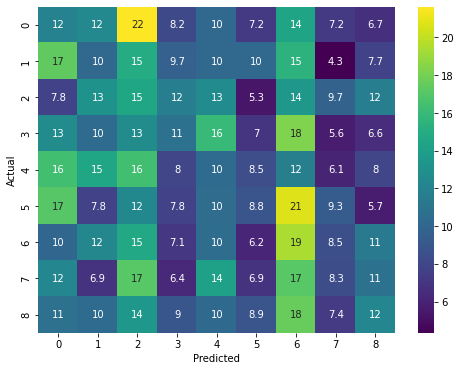

In [160]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Random Forest on pixels with LDA with V and undersampling

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_vectors.numpy(), labels.numpy(), test_size=0.2)

In [106]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [107]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
rf=RandomForestClassifier()
im_pipeline = make_pipeline(undersampler, lda, rf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'randomforestclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__m

Text(0, 0.5, 'mean test scores')

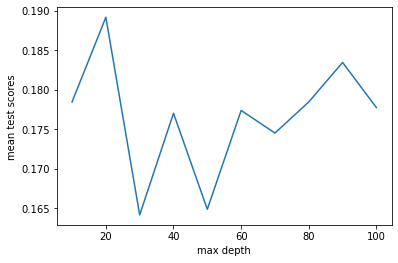

In [108]:
param_name = 'randomforestclassifier__max_depth'
param_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('max depth')
plt.ylabel('mean test scores')

Actual Model:

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [154]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [155]:
rf = RandomForestClassifier(max_depth=20)
rf_model = rf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_rf = rf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.08      0.12      0.09       208
           1       0.04      0.09      0.06       207
           2       0.06      0.12      0.08       206
           3       0.08      0.11      0.09       213
           4       0.07      0.20      0.11       213
           5       0.05      0.09      0.07       193
           6       0.09      0.17      0.12       211
           7       0.07      0.10      0.08       204
           8       0.62      0.15      0.24      1847

    accuracy                           0.14      3502
   macro avg       0.13      0.13      0.10      3502
weighted avg       0.36      0.14      0.17      3502



Text(0.5, 33.0, 'Predicted')

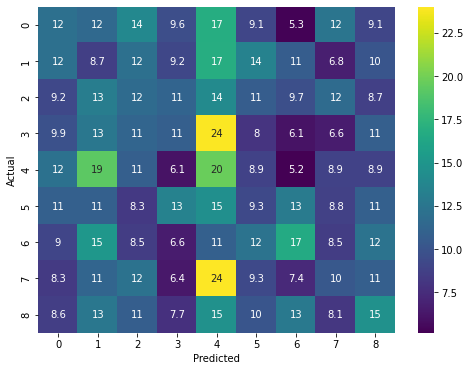

In [156]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Random Forest on engineered features with LDA with V and undersampling

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(edges_vectors.numpy(), labels.numpy(), test_size=0.2)

In [114]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [115]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
rf=RandomForestClassifier()
im_pipeline = make_pipeline(undersampler, lda, rf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'randomforestclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__m

Text(0, 0.5, 'mean test scores')

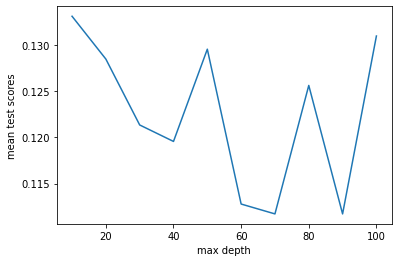

In [116]:
param_name = 'randomforestclassifier__max_depth'
param_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('max depth')
plt.ylabel('mean test scores')

Actual Model:

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [150]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [151]:
rf = RandomForestClassifier(max_depth=10)
rf_model = rf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_rf = rf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.07      0.10      0.08       208
           1       0.07      0.16      0.10       207
           2       0.05      0.10      0.07       206
           3       0.09      0.17      0.12       213
           4       0.07      0.15      0.09       213
           5       0.05      0.08      0.06       193
           6       0.08      0.18      0.11       211
           7       0.06      0.09      0.07       204
           8       0.57      0.13      0.21      1847

    accuracy                           0.13      3502
   macro avg       0.12      0.13      0.10      3502
weighted avg       0.34      0.13      0.15      3502



Text(0.5, 33.0, 'Predicted')

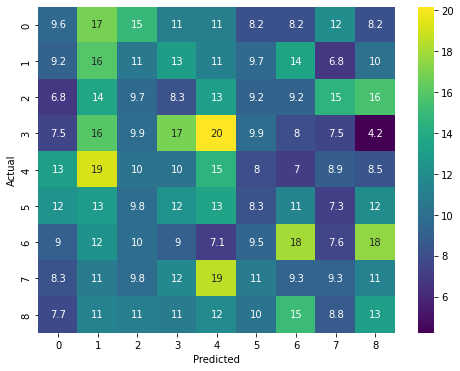

In [152]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Logistic Regression on pixels with LDA with V and undersampling

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_vectors.numpy(), labels.numpy(), test_size=0.2)

In [126]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [127]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
lr=LogisticRegression()
im_pipeline = make_pipeline(undersampler, lda, lr)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'logisticregression', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_

Text(0, 0.5, 'mean test scores')

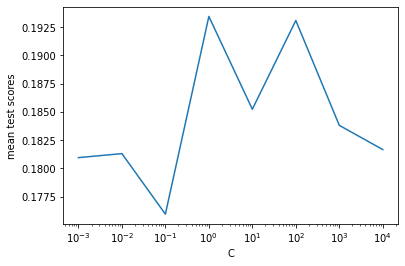

In [128]:
param_name = 'logisticregression__C'
param_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [146]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [147]:
lr = LogisticRegression(C=1)
lr_model = lr.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_lr = lr.predict(X_test_LDA)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.08      0.14      0.10       208
           1       0.07      0.13      0.09       207
           2       0.06      0.12      0.08       206
           3       0.08      0.13      0.10       213
           4       0.08      0.15      0.10       213
           5       0.05      0.09      0.06       193
           6       0.06      0.12      0.08       211
           7       0.07      0.13      0.09       204
           8       0.55      0.13      0.21      1847

    accuracy                           0.13      3502
   macro avg       0.12      0.13      0.10      3502
weighted avg       0.32      0.13      0.15      3502



Text(0.5, 33.0, 'Predicted')

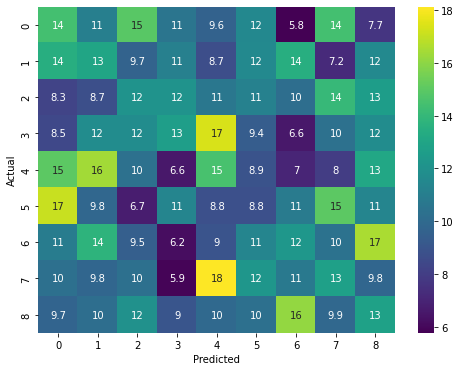

In [148]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Logistic Regression on engineered features with LDA with V and undersampling

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(edges_vectors.numpy(), labels.numpy(), test_size=0.2)

In [134]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [135]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
lr=LogisticRegression()
im_pipeline = make_pipeline(undersampler, lda, lr)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'logisticregression', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Text(0, 0.5, 'mean test scores')

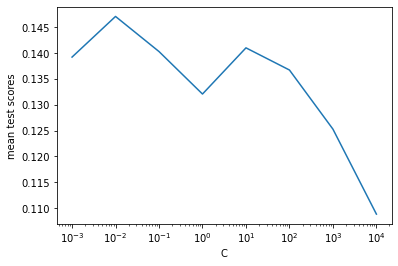

In [136]:
param_name = 'logisticregression__C'
param_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [142]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

In [143]:
lr = LogisticRegression(C=0.01)
lr_model = lr.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_lr = lr.predict(X_test_LDA)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.06      0.11      0.08       208
           1       0.06      0.11      0.08       207
           2       0.06      0.12      0.08       206
           3       0.09      0.14      0.11       213
           4       0.06      0.10      0.07       213
           5       0.04      0.07      0.05       193
           6       0.08      0.20      0.12       211
           7       0.08      0.14      0.10       204
           8       0.55      0.15      0.23      1847

    accuracy                           0.14      3502
   macro avg       0.12      0.12      0.10      3502
weighted avg       0.32      0.14      0.16      3502



Text(0.5, 33.0, 'Predicted')

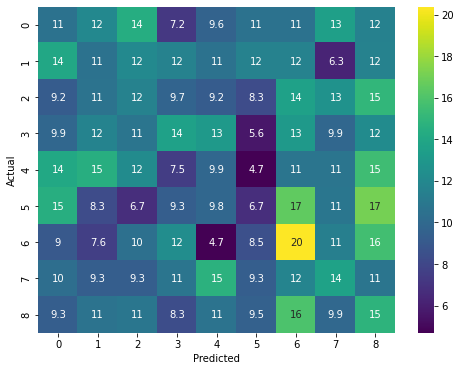

In [144]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")